# Tetraquad notebook

This Jupyter notebook demonstrates how to use basic feature of the tetraquad package.

For the mathematical details, please refer to the accompanying paper.

In [2]:
# Initialise
import tetraquad
import numpy as np
import matplotlib.pyplot as plt

The `tetrapyd' domain is defined as:

$ V_\mathcal{T} (k_\mathrm{min},k_\mathrm{max}) \equiv \{(k_1,k_2,k_3) : 2\max \{k_1, k_2, k_3\} \le k_1 + k_2 + k_3 \;\mathrm{and}\; k_\mathrm{min} \le k_1, k_2, k_3 \le k_\mathrm{max} \} $

A 'Quadrature' class instance specifies a quadrature rule which approximates the integral over tetrapyd as

$\int_{V_\mathcal{T}} dV f(\mathbf{x}) \approx \sum_n w_n f(\mathbf{x}_n)$

for some grid points $\{\mathbf{x}_n\}$ and their corresponding weights $w_n$.

In this package, the grid points are constructed by taking a uniform grid of size $N$ in each dimension so that $\sim(1/2) N^3$ points lie within the tetrapyd initially (the final number is often a lot smaller). For the 'tetraquad' quadrature, there is another parameter $M$ which relates to the Quadrature's precision; it dictates the maximum total order of symmetric polynomials that is almost exactly evaluated. If $N \ll M$, then there are not enough grid points to acheive the desired accuracy at high order polynomials. If $N \gg M$, then there are not enough constraints on the quadrature rule, degrading the overall performance at high orders. 

In [32]:
## Consider V_T(0.1, 1) in this notebook
alpha = 0.1

## Tetraquad rules with various size / precision
NM = [(10, 10), (10, 15), (15, 15)]
quads = [tetraquad.Quadrature(alpha, 1, N=N, M=M) for N, M in NM]
labels = [f"Tetraquad N={quad.N}, M={quad.M} ({len(quad.weights)} pts)" for quad in quads]

## 'Uniform' quadrature: 3D trapezoidal rule
uni_quad = tetraquad.Quadrature(alpha, 1, N=15, quad_type="uniform")
uni_label = f"Uniform N={uni_quad.N}, ({len(uni_quad.weights)} pts)"

## Note that an approximation using MC sampling is used for this quadrautre.
## For better precision, increase the number of MC samples (default: 10000)
#uni_quad = tetraquad.Quadrature(alpha, 1, N=15, quad_type="uniform", MC_n_samples=100000)

67 148
NNLS complete, rnorm 0.0002890807515437748
Out of 148 weights, 54 of them are nonzero
174 148
NNLS complete, rnorm 0.0007851498336489952
Out of 148 weights, 53 of them are nonzero
174 428
NNLS complete, rnorm 1.3900767619576336e-07
Out of 428 weights, 99 of them are nonzero


Let's test the most basic integral: $\int_{V_\mathcal{T}} dV = \mathrm{vol}(V_\mathcal{T})$

In [24]:
## Dataframe containing the grid point locations and their weights
df = quads[0].to_dataframe()
df.head(10)

## Save the quadrature to a csv format
#df.to_csv("test_quadrature.csv")

## Load the quadrature from a csv file.
## Note that metadata (N, M etc) are empty when you load this way (To be improved)
#loaded_quad = tetraquad.Quadrature.from_csv("test_quadrature.csv")

,k1,k2,k3,weight
0,0.2,0.2,0.1,0.003490
1,0.3,0.2,0.1,0.000533
2,0.3,0.2,0.2,0.006859
3,0.3,0.3,0.1,0.001329
4,0.3,0.3,0.3,0.006301
5,0.4,0.2,0.2,0.002193
6,0.4,0.3,0.2,0.001730
7,0.4,0.4,0.4,0.006478
8,0.5,0.3,0.2,0.004202
9,0.5,0.4,0.1,0.000575


A function $f(k_1, k_2, k_3)$ can be passed to evaluate the integrals. Note that the integrand must take three numpy arrays k1, k2, k3 and returns a numpy array of the same length.

In [34]:
## A constant function
def const(k1, k2, k3):
    return np.ones_like(k1)

print("Tetrapyd volume:", tetraquad.tetrapyd_volume(alpha, 1))

for quad, label in zip(quads, labels):
    ## Evaluate the integral
    eval = quad.integrate(const)
    print(label, ":", eval)

print(uni_label, ":", uni_quad.integrate(const))

Tetrapyd volume: 0.473
Tetraquad N=10, M=10 (54 pts) : 0.4729738519729912
Tetraquad N=10, M=15 (53 pts) : 0.4728071117998535
Tetraquad N=15, M=15 (99 pts) : 0.4729999999825153
Uniform N=15, (519 pts) : 0.4730286599999999


In [38]:
## Other test functions
func = tetraquad.symmetric_polynomial(10, 10, 10)
true_val = tetraquad.analytic_poly_integrals_alpha(10, 10, 10, alpha)

print("Analytic value:", true_val)
for quad, label in zip(quads, labels):
    ## Evaluate the integral
    eval = quad.integrate(func)
    print(label, ":", eval)

print(uni_label, ":", uni_quad.integrate(func))

Analytic value: [0.00075131]
Tetraquad N=10, M=10 (54 pts) : 0.0007224080737046952
Tetraquad N=10, M=15 (53 pts) : 0.0006871600252912854
Tetraquad N=15, M=15 (99 pts) : 0.000751023155800233
Uniform N=15, (519 pts) : 0.0007150047657304098


We provide a function to test the integrals over polynomials:

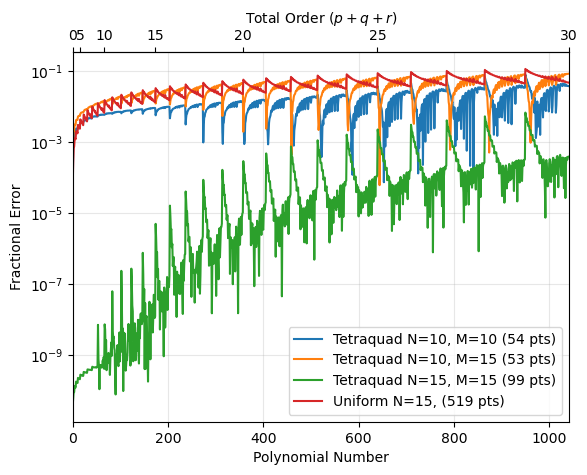

In [36]:
test = quads + [uni_quad]
test_labels = labels + [uni_label]

## Change max_degree to modify how many polynomials get tested
fig, ax = tetraquad.plot_test_polynomial_integration(test, alpha=alpha, labels=test_labels, max_degree=30)

By default, the quadrature rules have grid points on a slice of the tetrapyd with $k_1 \ge k_2 \ge k_3$.

It may sometimes be desirable to symmetrize the quadrature rule for visualization purposes:

In [39]:
sym_quads = [quad.symmetrize_quadrature() for quad in quads]
sym_uni_quad = uni_quad.symmetrize_quadrature()

Below is an optional visualization using the Python library named mayavi

In [40]:
from mayavi import mlab

sym_quad = sym_quads[-1]

fig = mlab.figure(size=(2048, 2048), bgcolor=(1,1,1))

k1, k2, k3 = sym_quad.grid
weights = sym_quad.weights

mlab.points3d(k1, k2, k3, weights, resolution=30, colormap="PuBu")

a, b = alpha, 1
side_0 = ([0., b, b, 0., 0.], [0., 0., b, b, 0.], [0., 0., 0., 0., 0.])

## Cube sides
tube_width = 0.003
mlab.plot3d(side_0[0], side_0[1], side_0[2], color=(0.7,0.7,0.7), tube_radius=tube_width)
mlab.plot3d(side_0[1], side_0[2], side_0[0], color=(0.7,0.7,0.7), tube_radius=tube_width)
mlab.plot3d(side_0[2], side_0[0], side_0[1], color=(0.7,0.7,0.7), tube_radius=tube_width)

mlab.plot3d([0., a], [b, b], [b, b], color=(0.7,0.7,0.7), tube_radius=tube_width)
mlab.plot3d([b, b], [0., a], [b, b], color=(0.7,0.7,0.7), tube_radius=tube_width)
mlab.plot3d([b, b], [b, b], [0., a], color=(0.7,0.7,0.7), tube_radius=tube_width)

## Tetrahedron sides
sides = ([a, a, b, a], [a, b, b, a], [a, b, a, a])
sides = ([a, 2*a, b, b, b-a, a, a], [a, a, a, a, a, a, a], [a, a, b-a, b, b, 2*a, a])
mlab.plot3d(sides[0], sides[1], sides[2], color=(0,0,0), tube_radius=tube_width)
mlab.plot3d(sides[1], sides[2], sides[0], color=(0,0,0), tube_radius=tube_width)
mlab.plot3d(sides[2], sides[0], sides[1], color=(0,0,0), tube_radius=tube_width)

mlab.plot3d([a, b-a], [b-a, a], [b, b], color=(0,0,0), tube_radius=tube_width)
mlab.plot3d([a, b-a], [b, b], [b-a, a], color=(0,0,0), tube_radius=tube_width)
mlab.plot3d([b, b], [a, b-a], [b-a, a], color=(0,0,0), tube_radius=tube_width)

mlab.plot3d([a, b], [b, b], [b, b], color=(0,0,0), tube_radius=tube_width)
mlab.plot3d([b, b], [a, b], [b, b], color=(0,0,0), tube_radius=tube_width)
mlab.plot3d([b, b], [b, b], [a, b], color=(0,0,0), tube_radius=tube_width)


mlab.view(azimuth=110, elevation=-73, distance=3.5, focalpoint='auto')
#mlab.savefig(f"../data_dir/tetraquad_gif/tetraquad.pdf")
mlab.show()